In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Dense,
                                   Flatten, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                           mean_squared_error, mean_absolute_error, r2_score,
                           roc_auc_score, classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime

In [ ]:
# Step 1: GPU Configuration (from first code)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

1 Physical GPUs, 1 Logical GPU


In [ ]:
# Step 2: Data Loading and Preprocessing
def load_ptbdb_data(normal_csv, abnormal_csv):
    """Loads and preprocesses the PTBDB dataset."""
    print("\nLoading PTBDB dataset...")

    # Load datasets
    df_normal = pd.read_csv(normal_csv, header=None)
    df_abnormal = pd.read_csv(abnormal_csv, header=None)

    # Combine and shuffle
    df = pd.concat([df_normal, df_abnormal], axis=0).sample(frac=1, random_state=42)

    # Features and labels
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    # Print class distribution
    print("\nOriginal class distribution:", Counter(y))

    return X, y

# Load the data
X, y = load_ptbdb_data("./ptbdb_normal.csv", "./ptbdb_abnormal.csv")



Loading PTBDB dataset...

Original class distribution: Counter({np.float64(1.0): 10506, np.float64(0.0): 4046})


In [ ]:
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Step 4: Handle class imbalance with SMOTE
print("\nOriginal class distribution:", Counter(y_train))

# Reshape for SMOTE (flatten the time series)
n_samples, n_timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, n_timesteps * n_features)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)
X_train_res = X_train_res.reshape(-1, n_timesteps, n_features)

print("After SMOTE class distribution:", Counter(y_train_res))


Original class distribution: Counter({np.float64(1.0): 8404, np.float64(0.0): 3237})
After SMOTE class distribution: Counter({np.float64(1.0): 8404, np.float64(0.0): 8404})


In [ ]:
# Step 5: Build enhanced LSTM model (from first code)
def create_model(input_shape):
    """Creates the LSTM model similar to first code's architecture."""
    model = Sequential()

    # Input shape: (timesteps, features)
    model.add(Conv1D(filters=64, kernel_size=15, activation='relu',
                    input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

# Create model with correct input shape
input_shape = (X_train_res.shape[1], X_train_res.shape[2])  # (timesteps, features)
model = create_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 173, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 82, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 41, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,689 (1.23 MB)

 Trainable params: 322,305 (1.23 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Step 6: TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Step 7: Train with callbacks
history = model.fit(X_train_res, y_train_res,
                  epochs=25,
                  batch_size=64,
                  validation_data=(X_test, y_test),verbose=1)

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7136 - loss: 0.5546 - val_accuracy: 0.5163 - val_loss: 0.9453
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8978 - loss: 0.2618 - val_accuracy: 0.8385 - val_loss: 0.3068
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9206 - loss: 0.2079 - val_accuracy: 0.9423 - val_loss: 0.1526
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9497 - loss: 0.1431 - val_accuracy: 0.9660 - val_loss: 0.0893
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9586 - loss: 0.1208 - val_accuracy: 0.9701 - val_loss: 0.0845
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9690 - loss: 0.0876 - val_accuracy: 0.9691 - val_loss: 0.0748
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9735 - loss: 0.0743 - val_accuracy: 0.9828 - val_loss: 0.0578
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9741 - loss: 0.0748 - val_acc

In [ ]:
# Step 8: Comprehensive evaluation
def calculate_all_metrics(y_true, y_pred, y_pred_proba):
    """Calculates all evaluation metrics."""
    metrics = {}

    # Basic classification metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['classification_report'] = classification_report(y_true, y_pred)

    # ROC AUC
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)

    # Regression metrics
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)

    return metrics

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Calculate all metrics
metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba)

# Print all metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print(f"Mean Squared Error: {metrics['mse']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"R-squared: {metrics['r2']:.4f}")

print("\nClassification Report:")
print(metrics['classification_report'])

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Model Performance Metrics:
Accuracy: 0.9859
F1 Score: 0.9902
ROC AUC: 0.9984
Mean Squared Error: 0.0141
Mean Absolute Error: 0.0141
R-squared: 0.9298

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       809
         1.0       1.00      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.98      0.99      0.98      2911
weighted avg       0.99      0.99      0.99      2911



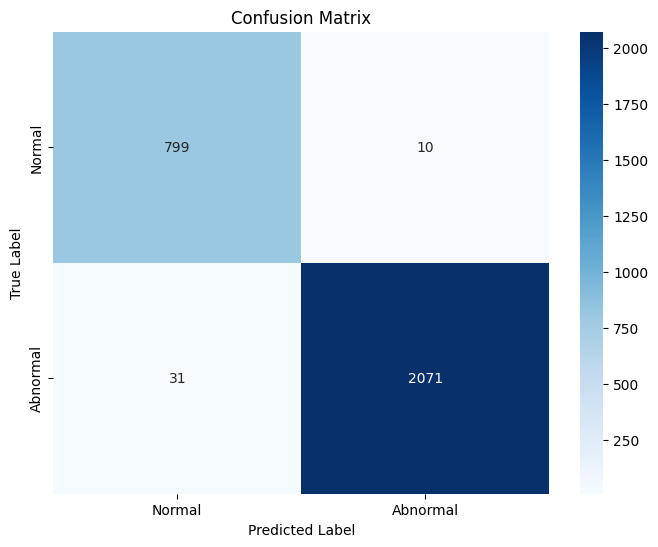

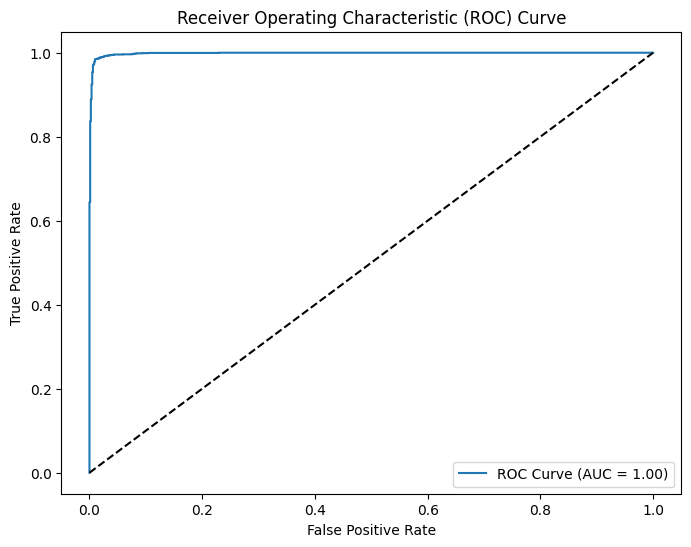

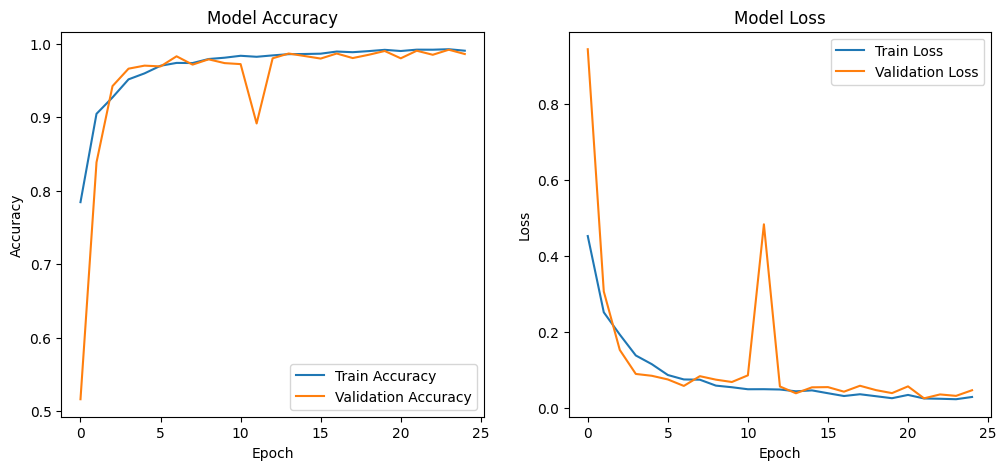

In [ ]:
# Step 9: Visualizations
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Step 10: Save Model
model.save('ecg_binary_classifier.h5')
print("\nModel saved successfully.")


Model saved successfully.
